In this project, I analyze Adsphere (a fictional ad platform) data to explore two research questions: (1) Do advertisers with the most campaigns/ads generate the most revenue? (2) How do ad presentation choices (formats, CTAs) differ across platforms and placements? The analysis uses SQL and Python (Seaborn/Matplotlib) to explore patterns and test relationships

In [333]:
!pip -q install mysql-connector-python SQLAlchemy pandas matplotlib

import sys, sqlalchemy, pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

print("Python:", sys.version.split()[0])
print("SQLAlchemy:", sqlalchemy.__version__)
print("pandas:", pd.__version__)

Python: 3.11.5
SQLAlchemy: 1.4.39
pandas: 2.0.3


In [315]:
# --- RDS Connection Settings ---
DB_HOST = "127.0.0.1"
DB_PORT = 3306
DB_NAME = "adsphere"

In [78]:
from getpass import getpass
DB_USER = input("MySQL username: ").strip()
DB_PASS = getpass("MySQL password: ").strip()

MySQL username: matt
MySQL password: ········


In [336]:
from sqlalchemy import create_engine, text

# 1) Connect to server (no DB) to verify credentials and list schemas
server_engine = create_engine(
    f"mysql+mysqlconnector://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}",
    pool_pre_ping=True,
)

with server_engine.connect() as conn:
    print("Ping:", conn.execute(text("SELECT 1")).scalar_one())
    dbs = pd.read_sql_query(text("SHOW DATABASES"), conn)
    # display(dbs)

    # 2) Ensure target DB exists; create it if needed (comment out if you don't want auto-create)
with server_engine.connect() as conn:
    conn.execute(text(f"CREATE DATABASE IF NOT EXISTS `{DB_NAME}` CHARACTER SET utf8mb4 COLLATE utf8mb4_0900_ai_ci;"))
    print(f"Verified database `{DB_NAME}`")

# 3) Connect directly to the target DB (still no SSL)
engine = create_engine(
    f"mysql+mysqlconnector://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    pool_pre_ping=True,
)

with engine.connect() as conn:
    print("SELECT 1 →", conn.execute(text("SELECT 1")).scalar_one())
    print("Current DB:", conn.execute(text("SELECT DATABASE()")).scalar_one())  # sanity check

    print("\nTables:")
    try:
        display(pd.read_sql_query(text("SHOW TABLES"), conn))
    except Exception as e:
        print("SHOW TABLES failed:", e)

    for t in ("ad", "campaign", "advertiser", "v_ad_performance", "platform"):
        try:
            print(f"\nDESCRIBE {t}:")
            display(pd.read_sql_query(text(f"DESCRIBE `{t}`"), conn))
        except Exception:
            pass

Ping: 1
Verified database `adsphere`
SELECT 1 → 1
Current DB: adsphere

Tables:


,Tables_in_adsphere
0,ad
1,ad_event
2,advertiser
3,campaign
4,country
5,device_type
6,event_type
7,placement
8,platform
9,user_profile



DESCRIBE ad:


,Field,Type,Null,Key,Default,Extra
0,ad_id,int,NO,PRI,None,auto_increment
1,campaign_id,int,NO,MUL,None,
2,platform_id,int,NO,MUL,None,
3,placement_id,int,NO,MUL,None,
4,name,varchar(160),NO,,None,
5,headline,varchar(180),NO,,None,
6,ad_text,text,NO,,None,
7,cta,"enum('Learn More','Shop Now','Sign Up','Downlo...",NO,,None,
8,bid_cents,int,NO,,None,
9,creative_format,"enum('image','video','carousel','text')",NO,,None,



DESCRIBE campaign:


,Field,Type,Null,Key,Default,Extra
0,campaign_id,int,NO,PRI,None,auto_increment
1,advertiser_id,int,NO,MUL,None,
2,name,varchar(160),NO,,None,
3,objective,"enum('reach','traffic','video_views','conversi...",NO,,None,
4,daily_budget,"decimal(10,2)",NO,,None,
5,start_date,date,NO,,None,
6,end_date,date,YES,,None,
7,status,"enum('active','paused','completed')",NO,,active,



DESCRIBE advertiser:


,Field,Type,Null,Key,Default,Extra
0,advertiser_id,int,NO,PRI,None,auto_increment
1,name,varchar(128),NO,UNI,None,
2,website,varchar(255),YES,,None,
3,country_id,int,YES,MUL,None,
4,industry,varchar(64),YES,,None,



DESCRIBE v_ad_performance:


,Field,Type,Null,Key,Default,Extra
0,ad_id,int,NO,,0,
1,ad_name,varchar(160),NO,,None,
2,platform,varchar(64),NO,,None,
3,placement,varchar(64),NO,,None,
4,campaign_id,int,NO,,0,
5,campaign_name,varchar(160),NO,,None,
6,advertiser_name,varchar(128),NO,,None,
7,impressions,"decimal(23,0)",YES,,None,
8,clicks,"decimal(23,0)",YES,,None,
9,purchases,"decimal(23,0)",YES,,None,



DESCRIBE platform:


,Field,Type,Null,Key,Default,Extra
0,platform_id,int,NO,PRI,None,auto_increment
1,name,varchar(64),NO,UNI,None,


Research Question 1: Are companies with the most active campaigns and ads also the top performers? 
Specifically, is there a correlation between ad volume and performance, or does having more ads not necessarily lead to higher results?

Step 1: Identify which advertisers maintain the highest number of active campaigns.

In [317]:
sql = """
SELECT a.name "Advertiser", a.industry "Industry", COUNT(c.campaign_id) "Number of Campaigns"
FROM advertiser a
INNER JOIN campaign c
ON a.advertiser_id = c.advertiser_id
WHERE c.status LIKE 'active'
GROUP BY Advertiser
ORDER BY count(c.campaign_id) DESC
LIMIT 20
"""
with engine.connect() as conn:
    df_1 = pd.read_sql_query(text(sql), conn)

df_1

,Advertiser,Industry,Number of Campaigns
0,Quantum Furniture,finance,4
1,Rocket Fitness 02,travel,3
2,Lunar Foods,cpg,3
3,Magnet Electronics 02,finance,3
4,Golden Books,gaming,2
5,Urban Market,saas,2
6,Rocket Outfitters,health,2
7,Quantum Outfitters,ecommerce,2
8,Silver Tools 02,ecommerce,2
9,Silver Furniture,travel,2


Next, I want to analyze advertisers at a more granular level by looking at the number of ads 
they run and the average number of ads per campaign. 
I focus only on active campaigns and ads to keep the analysis current. 
An INNER JOIN ensures we only include advertisers that actually have campaigns, 
while a LEFT JOIN on ads prevents inflating the "Avg Active Ads per Campaign" 
(since some advertisers may have campaigns without active ads).

In [318]:
sql = """
SELECT
a1.name Advertiser, a1.industry Industry, COUNT(DISTINCT(c.campaign_id)) "Number of Campaigns", 
COUNT(a2.ad_id) 'Number of Ads', 
ROUND(COUNT(a2.ad_id) * 1.0 / NULLIF(COUNT(DISTINCT c.campaign_id), 0),2) 'Avg Active Ads per Campaign'
FROM advertiser a1
INNER JOIN campaign c
ON c.advertiser_id = a1.advertiser_id
LEFT JOIN ad a2
ON a2.campaign_id = c.campaign_id
WHERE a2.status = 'active' AND c.status = 'active'
GROUP BY Advertiser
ORDER BY COUNT(a2.ad_id) DESC, COUNT(DISTINCT(c.campaign_id)) DESC
LIMIT 20;
"""
with engine.connect() as conn:
    df_2 = pd.read_sql_query(text(sql), conn)

df_2

,Advertiser,Industry,Number of Campaigns,Number of Ads,Avg Active Ads per Campaign
0,Quantum Furniture,finance,4,42,10.50
1,Rocket Fitness 02,travel,3,38,12.67
2,Magnet Electronics 02,finance,3,36,12.00
3,Blue Cloud,health,2,34,17.00
4,Lunar Foods,cpg,3,31,10.33
5,Quantum Outfitters,ecommerce,2,31,15.50
6,Bright Skincare,travel,2,30,15.00
7,Rocket Electronics,education,2,27,13.50
8,Green Games,health,2,25,12.50
9,Golden Auto,education,2,25,12.50


From the initial results, advertisers like Quantum Furniture and Rock Fitness 02 lead in active campaigns and ads, 
with Lunar Foods and Magnet Electronics 02 also appearing in the top five. 

Next, I shift focus to revenue under the same "active only" criteria. 
This is a good opportunity to use a CTE: it lets me identify the top-grossing advertisers 
while maintaining the filtering logic established earlier. 
I also include the count of distinct Ad IDs as a preview of whether ad volume 
might correlate with revenue performance.

In [319]:
sql = """
WITH active_ads AS (
SELECT a2.ad_id
FROM ad a2
JOIN campaign c
ON c.campaign_id = a2.campaign_id
AND c.status = 'active'
WHERE a2.status = 'active'
)
SELECT
v.advertiser_name,
COUNT(DISTINCT v.ad_id) active_ads,
SUM(v.impressions) impressions,
SUM(v.clicks) clicks,
SUM(v.total_revenue) total_revenue
FROM v_ad_performance v
JOIN active_ads aa
ON aa.ad_id = v.ad_id
GROUP BY v.advertiser_name
ORDER BY total_revenue DESC
LIMIT 20;
"""
with engine.connect() as conn:
    df_3 = pd.read_sql_query(text(sql), conn)

df_3

,advertiser_name,active_ads,impressions,clicks,total_revenue
0,Rocket Fitness 02,38,82.0,30.0,694.08
1,Urban Market,24,62.0,25.0,586.28
2,Apex Toys,23,62.0,15.0,454.02
3,Apex Electronics,9,28.0,5.0,414.06
4,Echo Tools,19,44.0,20.0,309.76
5,Apex Auto,16,32.0,16.0,303.93
6,Bright Music,16,37.0,10.0,274.58
7,Golden Books,19,48.0,10.0,262.99
8,Nova Toys,14,35.0,20.0,255.32
9,Vertex Books,9,21.0,7.0,249.65


The results highlight recurring top advertisers, with Rocket Fitness 02 and Quantum Furniture consistently 
appearing near the top. Other strong performers include Lunar Foods and Magnet Electronics 02. 
This reinforces the pattern that certain advertisers dominate across both campaign activity and revenue.

Now it’s time to place campaign volume and revenue performance side by side. 
Using another CTE allows both measures to be aligned and compared within a single query.

In [320]:
sql = """
WITH top_volume AS (
SELECT
a1.name AS advertiser_name, a1.industry AS industry,
COUNT(DISTINCT c.campaign_id) AS active_campaigns,
COUNT(a2.ad_id) AS active_ads,
ROUND(COUNT(a2.ad_id) * 1.0 / NULLIF(COUNT(DISTINCT c.campaign_id), 0),2) AS avg_active_ads_per_campaign
FROM advertiser a1
INNER JOIN campaign c
ON c.advertiser_id = a1.advertiser_id
AND c.status = 'active'
LEFT JOIN ad a2
ON a2.campaign_id = c.campaign_id
AND a2.status = 'active'
GROUP BY a1.name, a1.industry
),

active_ads AS (
SELECT a2.ad_id, c.advertiser_id
FROM ad a2
JOIN campaign c
ON c.campaign_id = a2.campaign_id
AND c.status = 'active'
WHERE a2.status = 'active'
),

top_perf AS (
SELECT
v.advertiser_name,
COUNT(DISTINCT v.ad_id) AS active_ads,
SUM(v.impressions) AS impressions,
SUM(v.clicks) AS clicks,
SUM(v.total_revenue) AS total_revenue
FROM v_ad_performance v
JOIN active_ads aa
ON aa.ad_id = v.ad_id
GROUP BY v.advertiser_name
)

SELECT
v.advertiser_name,
v.active_ads,
v.active_campaigns,
p.total_revenue,
p.impressions,
p.clicks
FROM top_volume v
INNER JOIN top_perf p
ON p.advertiser_name = v.advertiser_name
ORDER BY p.total_revenue DESC
LIMIT 20;
"""
with engine.connect() as conn:
    df_4 = pd.read_sql_query(text(sql), conn)

df_4

,advertiser_name,active_ads,active_campaigns,total_revenue,impressions,clicks
0,Rocket Fitness 02,38,3,694.08,82.0,30.0
1,Urban Market,24,2,586.28,62.0,25.0
2,Apex Toys,23,2,454.02,62.0,15.0
3,Apex Electronics,9,1,414.06,28.0,5.0
4,Echo Tools,19,2,309.76,44.0,20.0
5,Apex Auto,16,1,303.93,32.0,16.0
6,Bright Music,16,1,274.58,37.0,10.0
7,Golden Books,19,2,262.99,48.0,10.0
8,Nova Toys,14,1,255.32,35.0,20.0
9,Vertex Books,9,1,249.65,21.0,7.0


This comparison helps identify which advertisers are strong in both campaign activity and revenue. 
To formally test correlation between ad volume and performance, I make slight adjustments to the query 
and then visualize the relationship using Seaborn and Matplotlib.

ROAS (Return on Ad Spend) is included as a performance metric in this query. 
Since the goal is visualization, no ordering is applied in the SQL so that results can be plotted directly.

In [322]:
sql = """
WITH active_ads AS (
SELECT a2.ad_id, c.advertiser_id
FROM ad a2
JOIN campaign c
ON c.campaign_id = a2.campaign_id
AND c.status = 'active'
WHERE a2.status = 'active'
),

top_volume AS (
SELECT a1.advertiser_id,
COUNT(DISTINCT c.campaign_id) active_campaigns,
COUNT(DISTINCT a2.ad_id) active_ads
FROM advertiser a1
JOIN campaign c
ON c.advertiser_id = a1.advertiser_id
AND c.status = 'active'
LEFT JOIN ad a2
ON a2.campaign_id = c.campaign_id
AND a2.status = 'active'
GROUP BY a1.advertiser_id
),

top_perf AS (
SELECT ca.advertiser_id,
SUM(v.impressions) impressions,
SUM(v.clicks) clicks,
SUM(v.total_cost) total_cost,
SUM(v.total_revenue) total_revenue,
CASE WHEN SUM(v.total_cost) > 0 THEN SUM(v.total_revenue)/SUM(v.total_cost) END ROAS
FROM active_ads ca
JOIN v_ad_performance v
ON v.ad_id = ca.ad_id
GROUP BY ca.advertiser_id
)

SELECT a.advertiser_id, a.name advertiser_name,
top_volume.active_campaigns, top_volume.active_ads,
top_perf.impressions, top_perf.clicks,
top_perf.total_cost, top_perf.total_revenue, top_perf.ROAS
FROM advertiser a
JOIN top_volume
ON a.advertiser_id = top_volume.advertiser_id
JOIN top_perf
ON a.advertiser_id = top_perf.advertiser_id;
"""
with engine.connect() as conn:
    df_5 = pd.read_sql_query(text(sql), conn)

df_5

,advertiser_id,advertiser_name,active_campaigns,active_ads,impressions,clicks,total_cost,total_revenue,ROAS
0,2,Urban Market,2,24,62.0,25.0,31.9551,586.28,18.346993
1,3,Silver Tools,1,10,33.0,9.0,9.8253,160.03,16.287543
2,4,Bright Music,1,16,37.0,10.0,13.5843,274.58,20.213040
3,5,Lunar Toys,1,14,41.0,6.0,8.2000,113.77,13.874390
4,6,Lunar Foods,3,31,65.0,29.0,29.0920,0.00,0.000000
...,...,...,...,...,...,...,...,...,...
57,112,Phoenix Studios,2,20,56.0,14.0,13.6580,0.00,0.000000
58,115,Prime Travel 02,1,7,19.0,5.0,3.2183,0.00,0.000000
59,116,Nova Toys,1,14,35.0,20.0,17.0214,255.32,14.999941
60,117,Green Games,2,25,72.0,24.0,24.3393,97.79,4.017782


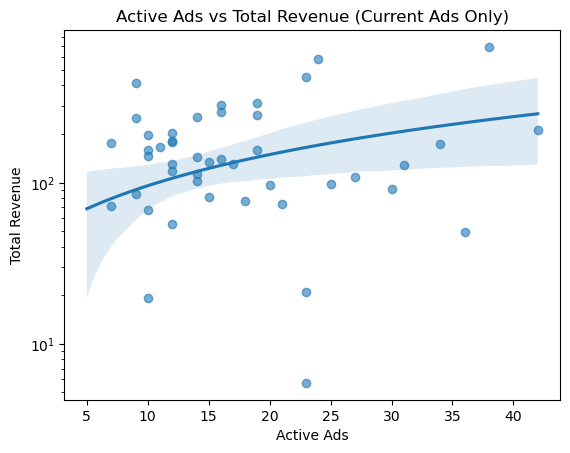

In [303]:
ax = sb.regplot(data=df_5, x="active_ads", y="total_revenue", scatter_kws={'alpha':0.6})
ax.set_title("Active Ads vs Total Revenue (Current Ads Only)")
ax.set_xlabel("Active Ads")
ax.set_ylabel("Total Revenue")

ax.set_yscale("log")

plt.show()

The regression line trends upward, indicating that on average, advertisers with more active ads 
also generate more total revenue. However, the wide scatter shows that advertisers with a similar number of ads can achieve very different 
revenue levels, and several outliers are present. 

Conclusion for RQ1: There is evidence of a positive correlation between ad volume and revenue, but correlation does not imply causation. Having more ads does not guarantee higher revenue, 
though it is often associated with it.

Moving on to Research Question 2: How do ad presentation choices differ across platforms and placements? 
Specifically, which CTA + format combinations are most commonly used and most effective in driving clicks? 

For this analysis, I consider all ads (active and inactive) to capture the full range of presentation strategies.

To begin exploring RQ2, I start with a basic frequency check: 
counting how many ads use each creative format. 
This provides a baseline view of how ad presentation formats are distributed across the dataset.

In [323]:
sql = """
SELECT COUNT(ad_id) "Number of Ads", creative_format "Format"
FROM ad
GROUP BY creative_format
ORDER BY COUNT(ad_id) DESC
"""
with engine.connect() as conn:
    df_6 = pd.read_sql_query(text(sql), conn)

df_6

,Number of Ads,Format
0,796,video
1,748,image
2,747,text
3,709,carousel


The next step is to examine how creative formats are distributed across different platforms. 
Adding platform context allows us to see whether certain formats are preferred on specific platforms.

In [325]:
sql = """
SELECT COUNT(a.ad_id) "Number of Ads", a.creative_format "Format", p.name "Platform"
FROM ad a
INNER JOIN Platform p
ON a.platform_id = p.platform_id
GROUP BY p.name, a.creative_format
ORDER BY P.name ASC, COUNT(a.ad_id) DESC
"""
with engine.connect() as conn:
    df_7 = pd.read_sql_query(text(sql), conn)

df_7

,Number of Ads,Format,Platform
0,134,image,Chatter
1,112,video,Chatter
2,109,text,Chatter
3,107,carousel,Chatter
4,143,video,FaceWorld
5,132,image,FaceWorld
6,129,text,FaceWorld
7,104,carousel,FaceWorld
8,137,text,InstaPic
9,131,carousel,InstaPic


Next, I calculate what share of each platform’s ads belong to each creative format. 
This highlights how formats are distributed within platforms, not just in overall counts.

In [326]:
sql = """
WITH total_ads AS (
SELECT a.platform_id, COUNT(a.ad_id) total_ads
FROM ad a
JOIN platform p
ON a.platform_id = p.platform_id
GROUP BY a.platform_id
),

format_ads AS (
SELECT a.platform_id, a.creative_format, COUNT(a.ad_id) format_ads
FROM ad a
GROUP BY a.platform_id, a.creative_format
)

SELECT
p.name "Platform",
fa.creative_format  "Format",
fa.format_ads AS "Number of Ads",
ROUND(fa.format_ads * 1.0 / t.total_ads, 3) "Share"
FROM format_ads fa
INNER JOIN total_ads t
ON t.platform_id = fa.platform_id
INNER JOIN platform p
ON p.platform_id = fa.platform_id
ORDER BY p.name ASC, "Share" DESC;
"""
with engine.connect() as conn:
    df_8 = pd.read_sql_query(text(sql), conn)

df_8

,Platform,Format,Number of Ads,Share
0,Chatter,video,112,0.242
1,Chatter,image,134,0.290
2,Chatter,text,109,0.236
3,Chatter,carousel,107,0.232
4,FaceWorld,image,132,0.260
5,FaceWorld,text,129,0.254
6,FaceWorld,carousel,104,0.205
7,FaceWorld,video,143,0.282
8,InstaPic,carousel,131,0.249
9,InstaPic,video,129,0.245


This breakdown enables a more detailed analysis of how each platform allocates its ads across creative formats. 
It provides context for comparing not only overall volumes but also relative usage patterns by platform.

Next, I examine which CTAs are most frequently used on each platform. 
This highlights how different platforms emphasize particular calls-to-action.

In [327]:
sql = """
SELECT COUNT(a.ad_id) "Number of Ads", a.cta "CTA", p.name "Platform"
FROM ad a
INNER JOIN platform p
ON a.platform_id = p.platform_id
GROUP BY p.name, a.cta
ORDER BY p.name ASC, COUNT(a.ad_id) DESC
"""
with engine.connect() as conn:
    df_9 = pd.read_sql_query(text(sql), conn)

df_9

,Number of Ads,CTA,Platform
0,90,Download,Chatter
1,88,Sign Up,Chatter
2,76,Get Offer,Chatter
3,75,Shop Now,Chatter
4,72,Subscribe,Chatter
5,61,Learn More,Chatter
6,99,Subscribe,FaceWorld
7,90,Shop Now,FaceWorld
8,90,Download,FaceWorld
9,83,Learn More,FaceWorld


Having gathered frequency data, the analysis now shifts from identifying what is most common 
to evaluating what is most engaging.

To evaluate engagement, I measure which CTA and creative format combinations generate the most clicks per platform. 
A LEFT JOIN is used to include all ads while still bringing in performance data when available.

In [328]:
sql = """
SELECT COUNT(a.ad_id) "Number of Ads", a.cta "CTA", p.name "Platform", SUM(v.clicks) "Clicks", 
(SUM(v.clicks) / COUNT(a.ad_id) * 1.0) "avg_clicks_per_ad"
FROM ad a
INNER JOIN platform p
ON a.platform_id = p.platform_id
LEFT JOIN v_ad_performance v
ON a.ad_id = v.ad_id
GROUP BY p.name, a.cta
ORDER BY (SUM(v.clicks) / COUNT(a.ad_id) * 1.0) DESC
"""
with engine.connect() as conn:
    df_10 = pd.read_sql_query(text(sql), conn)

df_10

,Number of Ads,CTA,Platform,Clicks,avg_clicks_per_ad
0,90,Get Offer,InstaPic,94.0,1.0444
1,82,Download,SnapGram,77.0,0.9390
2,87,Shop Now,SnapGram,81.0,0.9310
3,99,Sign Up,SnapGram,92.0,0.9293
4,72,Subscribe,Chatter,64.0,0.8889
5,109,Subscribe,LinkLine,96.0,0.8807
6,81,Learn More,SnapGram,70.0,0.8642
7,87,Shop Now,TokTik,75.0,0.8621
8,88,Sign Up,LinkLine,75.0,0.8523
9,67,Learn More,LinkLine,57.0,0.8507


Next, I connect the pieces by asking: which CTAs are top performers across multiple contexts? 
This is done by intersecting the most frequently used CTAs with the highest-performing ones. 
NULLIF is included in the calculation to safely handle cases where no ads are present, 
avoiding divide-by-zero errors.

In [329]:
sql = """
WITH cta_counts AS (
SELECT
a.cta cta,
COUNT(a.ad_id) num_ads,
SUM(v.clicks) total_clicks,
SUM(v.clicks) * 1.0 / NULLIF(COUNT(a.ad_id), 0) avg_clicks_per_ad
FROM ad a
LEFT JOIN v_ad_performance v
ON v.ad_id = a.ad_id
GROUP BY a.cta
),

top_freq AS (
SELECT cta
FROM cta_counts
ORDER BY num_ads DESC
LIMIT 5
),

top_engagement AS (
SELECT cta
FROM cta_counts
ORDER BY avg_clicks_per_ad DESC
LIMIT 5
)

SELECT c.cta, c.num_ads, c.total_clicks, c.avg_clicks_per_ad
FROM cta_counts c
INNER JOIN top_freq f 
ON f.cta = c.cta
INNER 
JOIN top_engagement e 
ON e.cta = c.cta
ORDER BY c.avg_clicks_per_ad DESC;
"""
with engine.connect() as conn:
    df_11 = pd.read_sql_query(text(sql), conn)

df_11

,cta,num_ads,total_clicks,avg_clicks_per_ad
0,Get Offer,490,401.0,0.81837
1,Subscribe,539,434.0,0.80519
2,Download,510,408.0,0.80000
3,Sign Up,495,392.0,0.79192


These results represent the CTAs that are both widely used by advertisers 
and among the strongest performers with users. 
The intersection approach ensures the list highlights CTAs that succeed on both dimensions: 
popularity and engagement.

Finally, I compare CTA performance across two specific creative formats: video and image. 
The goal is to see which CTAs generate the most engagement in video ads compared to image ads.

In [330]:
sql = """
WITH format_cta AS (
SELECT
a.creative_format,
a.cta,
COUNT(a.ad_id) num_ads,
SUM(v.clicks) total_clicks,
SUM(v.clicks) * 1.0 / NULLIF(COUNT(a.ad_id),0) avg_clicks_per_ad
FROM ad a
LEFT JOIN v_ad_performance v
ON v.ad_id = a.ad_id
WHERE a.creative_format IN ('video','image')
GROUP BY a.creative_format, a.cta
)

SELECT *
FROM format_cta
ORDER BY avg_clicks_per_ad DESC;
"""
with engine.connect() as conn:
    df_12 = pd.read_sql_query(text(sql), conn)

df_12

,creative_format,cta,num_ads,total_clicks,avg_clicks_per_ad
0,image,Learn More,116,109.0,0.93966
1,image,Get Offer,123,106.0,0.86179
2,video,Shop Now,132,111.0,0.84091
3,video,Download,126,105.0,0.83333
4,video,Subscribe,157,130.0,0.82803
5,image,Sign Up,143,117.0,0.81818
6,video,Sign Up,115,93.0,0.80870
7,image,Shop Now,108,87.0,0.80556
8,image,Download,131,105.0,0.80153
9,video,Get Offer,138,105.0,0.76087


To support the conclusion, I create a visualization. 
A grouped bar plot is used to compare CTAs by average clicks, with creative format as an additional dimension. 
This highlights differences in CTA effectiveness between image and video ads.

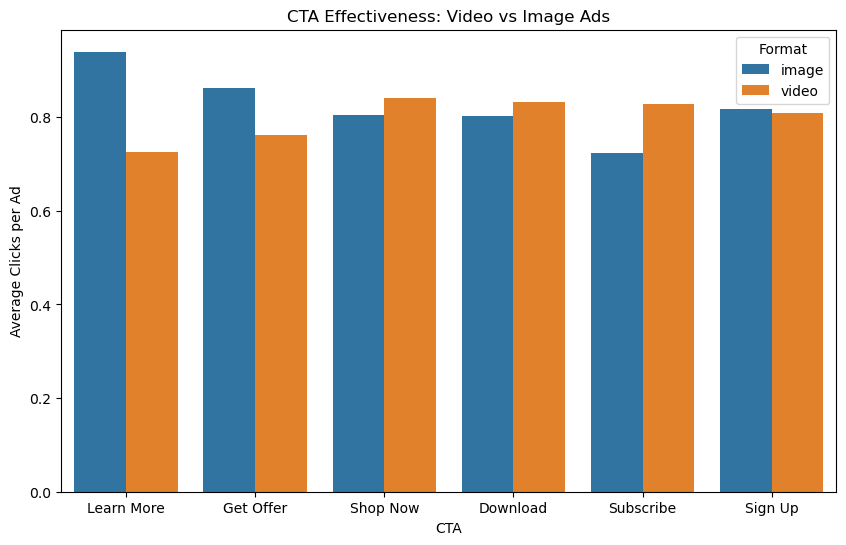

In [313]:
plt.figure(figsize=(10,6))
ax = sb.barplot(data=df_12, x="cta", y="avg_clicks_per_ad", hue="creative_format")

ax.set_title("CTA Effectiveness: Video vs Image Ads")
ax.set_xlabel("CTA")
ax.set_ylabel("Average Clicks per Ad")

plt.legend(title="Format")
plt.show()

Overall, there is no single format that consistently outperforms the other. 
Effectiveness depends on the combination of CTA and format: for example, "Learn More" is strongest in image ads, 
while "Subscribe" performs best in video. 

Conclusion for RQ2: Ad presentation choices vary by platform and placement, and performance depends not on 
the CTA or the format alone, but on how the two are paired together.